In [1]:
# Install open slide to view .tif files
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pickle
import gc

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Accessing Data from Drive - 12 slides with their mask**

In [4]:
slides_folder = ('/content/gdrive/My Drive/ADL_Project_Data')

slideNames = []
masksNames = [] 

for file in os.listdir(slides_folder): 
    if "tif" in file and "mask" not in file:
        maskname = file[:-4]+"_mask.tif"
        masksNames.append(maskname)
        slideNames.append(file)

In [5]:
slideNames.sort()
masksNames.sort()
print(slideNames)
print(masksNames)

['tumor_001.tif', 'tumor_002.tif', 'tumor_005.tif', 'tumor_012.tif', 'tumor_016.tif', 'tumor_059.tif', 'tumor_064.tif', 'tumor_091.tif', 'tumor_094.tif', 'tumor_096.tif', 'tumor_101.tif', 'tumor_110.tif']
['tumor_001_mask.tif', 'tumor_002_mask.tif', 'tumor_005_mask.tif', 'tumor_012_mask.tif', 'tumor_016_mask.tif', 'tumor_059_mask.tif', 'tumor_064_mask.tif', 'tumor_091_mask.tif', 'tumor_094_mask.tif', 'tumor_096_mask.tif', 'tumor_101_mask.tif', 'tumor_110_mask.tif']


In [6]:
path = '/content/gdrive/My Drive/ADL_Project_Data'
slides = []
for file in slideNames:
    slides.append(os.path.join(path,file))  

masks = []
for file in masksNames:
    masks.append(os.path.join(path,file))

In [7]:
print(slides)
print(masks)
print("Total Slides Files in Directory", len(slides))
print("Total Masks Files in Directory", len(masks))

['/content/gdrive/My Drive/ADL_Project_Data/tumor_001.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_002.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_005.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_012.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_016.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_059.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_064.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_091.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_094.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_096.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_101.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_110.tif']
['/content/gdrive/My Drive/ADL_Project_Data/tumor_001_mask.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_002_mask.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_005_mask.tif', '/content/gdrive/My Drive/ADL_Project_Data/tumor_012_mask.tif', '/content/gdrive/My Drive/ADL_Proj

**Printing height & width for each zoom level present for the slide**

In [8]:
for slide in slides:
    slide_img = open_slide(slide)
    print("Slide:{}".format(slide))
    for i in range(len(slide_img.level_dimensions)):
        width, height = slide_img.level_dimensions[i]
        print("level :{}, downsample_factor: {}, width: {} height: {}".format(i,slide_img.level_downsamples[i], width,height,i))
    print("\n")

Slide:/content/gdrive/My Drive/ADL_Project_Data/tumor_001.tif
level :0, downsample_factor: 1.0, width: 97792 height: 221184
level :1, downsample_factor: 2.0, width: 48896 height: 110592
level :2, downsample_factor: 4.0, width: 24448 height: 55296
level :3, downsample_factor: 8.0, width: 12224 height: 27648
level :4, downsample_factor: 16.0, width: 6112 height: 13824
level :5, downsample_factor: 32.0, width: 3056 height: 6912
level :6, downsample_factor: 64.0, width: 1528 height: 3456
level :7, downsample_factor: 128.0, width: 764 height: 1728
level :8, downsample_factor: 256.0, width: 382 height: 864
level :9, downsample_factor: 512.0, width: 191 height: 432


Slide:/content/gdrive/My Drive/ADL_Project_Data/tumor_002.tif
level :0, downsample_factor: 1.0, width: 97792 height: 219648
level :1, downsample_factor: 2.0, width: 48896 height: 109824
level :2, downsample_factor: 4.0, width: 24448 height: 54912
level :3, downsample_factor: 8.0, width: 12224 height: 27456
level :4, downsample_fa

**Displaying all 12 slides at level 5**

In [9]:
# Read a portion of a .tif file
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [10]:
#displaying all slides of level 5  with their mask
slideList = []
maskList=[]
for posIndex in range(12):
    slide = slides[posIndex]
    mask = masks[posIndex]

    l = 5
    slide_img =open_slide(slide)
    masks_img = open_slide(mask)
    w = slide_img.level_dimensions[l][0]
    h = slide_img.level_dimensions[l][1]

    slide_image=read_slide(slide_img, x=0, y=0, level=l, width=w, height=h)
    mask_image= read_slide(masks_img,x=0,y=0,level=l,width=w,height=h)
    mask_image = mask_image[:,:,0]
    slideList.append(slide_image)
    maskList.append(mask_image)


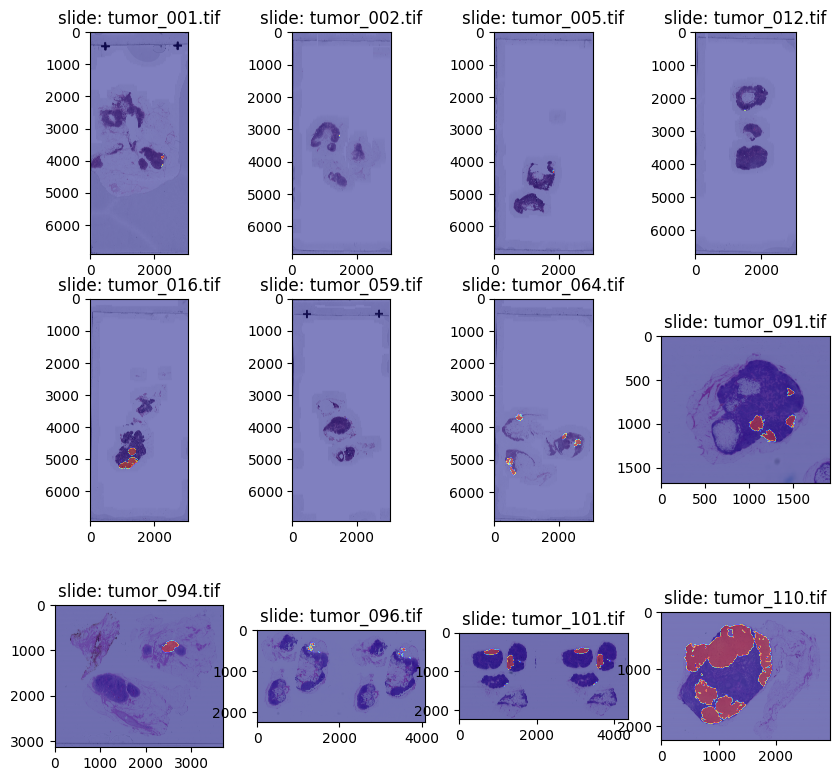

In [11]:
fig, axs = plt.subplots(3, 4,figsize=(10, 10),dpi=100)
pos = 0
for i in range(3):
    for j in range(4):
        axs[i][j].imshow(slideList[pos])
        axs[i][j].imshow(maskList[pos], cmap='jet', alpha=0.5)
        axs[i][j].set_title("slide: {}".format(slideNames[pos]))
        pos = pos + 1

In [12]:
del slideList,maskList
gc.collect()

52

**Experimenting with slide 7 to see a particular pixels at different zoom level - [5, 3 , 2]**

**1) Displaying full slide 7 at zoom level 5**

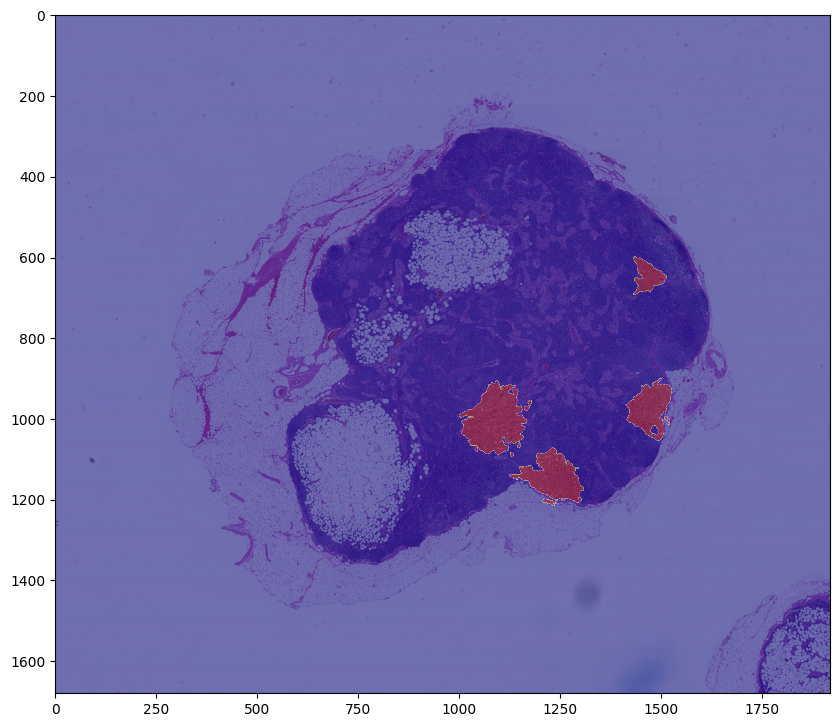

In [13]:
posIndex = 7
slide = slides[posIndex]
mask = masks[posIndex]

l = 5
slide_img =open_slide(slide)
masks_img = open_slide(mask)
w = slide_img.level_dimensions[l][0]
h = slide_img.level_dimensions[l][1]

slide_image=read_slide(slide_img, x=0, y=0, level=l, width=w, height=h)
mask_image= read_slide(masks_img,x=0,y=0,level=l,width=w,height=h)
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.


**2) Picking pixels (x = 1250 y = 1160) and displaying a patch of [100 * 100] at zoom levels 5, 3 & 2**

In [14]:
level = 5
downsamplingFactor = 2 ** level
dx = 1250 
dy = 1140
requiredPixel = 100

In [15]:
'''
# list to append patches 
  zeroth index will be slide and first index will be mask
'''
patch_level_5 = []
patch_level_3 = []
patch_level_2 = []


In [16]:
'''
1) slide and mask at the pixel (x = 1250 y = 1160) with level 5
2) getting a patch of 100 * 100
'''
slide_image=read_slide(slide_img, 
                       x=dx*downsamplingFactor, 
                       y=dy*downsamplingFactor, 
                       level=l, 
                       width=requiredPixel, 
                       height=requiredPixel)
mask_image= read_slide(masks_img,
                       x=dx*downsamplingFactor,
                       y=dy*downsamplingFactor,
                       level=l,
                       width=requiredPixel,
                       height=requiredPixel)
mask_image = mask_image[:,:,0]
patch_level_5.append(slide_image)
patch_level_5.append(mask_image)

'''
1) slide and mask at the pixel (x = 1250 y = 1160) with level 3 
2) getting a patch of 300 * 300 (thrice the initial image, 
    so that we can cover more pixels in zoom out level)
'''

# slide and mask at the same pixel with level 3 
zoomFactor = 2
zoom_slide_image=read_slide(slide_img, 
                            x=dx*downsamplingFactor, 
                            y=dy*downsamplingFactor, 
                            # level 3 
                            level=level-2, 
                            # scaling with zoomFactor to get more pixels
                            width=requiredPixel*zoomFactor, 
                            # scaling with zoomFactor to get more pixels
                            height=requiredPixel*zoomFactor) 

zoom_mask_image= read_slide(masks_img,
                            x=dx*downsamplingFactor,
                            y=dy*downsamplingFactor,
                            # level 3
                            level=level-2,  
                            # scaling with zoomFactor to get more pixels
                            width=requiredPixel*zoomFactor, 
                            # scaling with zoomFactor to get more pixels
                            height=requiredPixel*zoomFactor) 

zoom_mask_image = zoom_mask_image[:,:,0]


patch_level_3.append(zoom_slide_image)
patch_level_3.append(zoom_mask_image)


'''
1) slide and mask at the pixel (x = 1250 y = 1160) with level 2
2) getting a patch of 400 * 400 (four times the initial image, 
    so that we can cover more pixels in zoom out level)
'''

# slide and mask at the same pixel with level 2 

zoomFactor = 4
zoom_slide_image=read_slide(slide_img, 
                            x=dx*downsamplingFactor, 
                            y=dy*downsamplingFactor, 
                            # level 2 
                            level=level-1, 
                            # scaling with zoomFactor to get more pixels
                            width=requiredPixel*zoomFactor, 
                            # scaling with zoomFactor to get more pixels
                            height=requiredPixel*zoomFactor) 

zoom_mask_image= read_slide(masks_img,
                            x=dx*downsamplingFactor,
                            y=dy*downsamplingFactor,
                            # level 3
                            level=level-2,  
                            # scaling with zoomFactor to get more pixels
                            width=requiredPixel*zoomFactor, 
                            # scaling with zoomFactor to get more pixels
                            height=requiredPixel*zoomFactor) 

zoom_mask_image = zoom_mask_image[:,:,0]

patch_level_2.append(zoom_slide_image)
patch_level_2.append(zoom_mask_image)

Text(0.5, 1.0, 'level 2 - [400 * 400]')

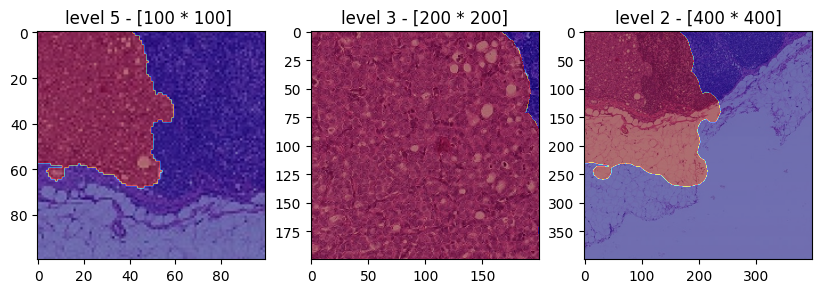

In [17]:
fig, axs = plt.subplots(1, 3,figsize=(10, 10),dpi=100)
axs[0].imshow(patch_level_5[0])
axs[0].imshow(patch_level_5[1],cmap='jet', alpha=0.5)
axs[0].set_title("level 5 - [100 * 100] ")

axs[1].imshow(patch_level_3[0])
axs[1].imshow(patch_level_3[1],cmap='jet', alpha=0.5)
axs[1].set_title("level 3 - [200 * 200]")

axs[2].imshow(patch_level_2[0])
axs[2].imshow(patch_level_2[1],cmap='jet', alpha=0.5)
axs[2].set_title("level 2 - [400 * 400]")


**For zoom out levels i.e. 3  & 2, cropping the image in a way to extract center to make it equivalent to [100 * 100] pixels**

*Done especially to reduce overall memory consumption*

In [18]:
patch_level_3_cropped = []
patch_level_2_cropped = []

In [19]:
def cropImg(img, requiredWidth, requiredHeight, centerList, flag):
  pixel_x = centerList[1] - requiredWidth/2
  pixel_y = centerList[0] - requiredHeight/2
  if(flag=='mask'):
    return img[int(pixel_y):int(pixel_y+requiredHeight),
               int(pixel_x):int(pixel_x+requiredWidth)]
  else:
    return img[int(pixel_y):int(pixel_y+requiredHeight), 
             int(pixel_x):int(pixel_x+requiredWidth), :]

In [20]:
zoom_slide_image = patch_level_3[0]
zoom_mask_image = patch_level_3[1]
size = 300 
requiredPixel = 100 
centerPixel = size / 2 
slide_image = cropImg(zoom_slide_image,
                      requiredPixel,
                      requiredPixel,
                      (centerPixel,centerPixel),
                      'slide')
mask_image = cropImg(zoom_mask_image,
                     requiredPixel,
                     requiredPixel,
                     (centerPixel,centerPixel),
                     'mask')

patch_level_3_cropped.append(slide_image)
patch_level_3_cropped.append(mask_image)

In [21]:
zoom_slide_image = patch_level_2[0]
zoom_mask_image = patch_level_2[1]
size = 400 
requiredPixel = 100 
centerPixel = size / 2 
slide_image = cropImg(zoom_slide_image,
                      requiredPixel,
                      requiredPixel,
                      (centerPixel,centerPixel),
                      'slide')
mask_image = cropImg(zoom_mask_image,
                     requiredPixel,
                     requiredPixel,
                     (centerPixel,centerPixel),
                     'mask')

patch_level_2_cropped.append(slide_image)
patch_level_2_cropped.append(mask_image)

Text(0.5, 1.0, 'level 2 - [100 * 100]')

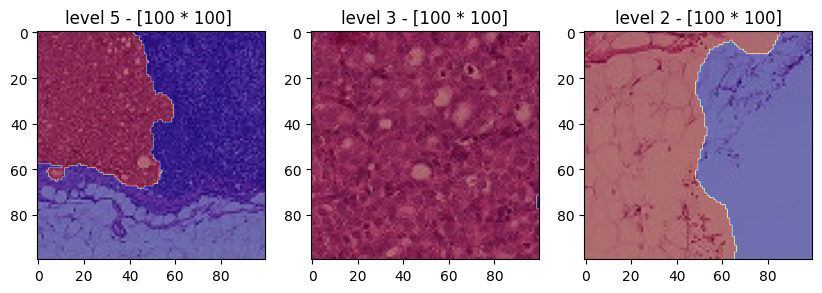

In [22]:
fig, axs = plt.subplots(1, 3,figsize=(10, 10),dpi=100)
axs[0].imshow(patch_level_5[0])
axs[0].imshow(patch_level_5[1],cmap='jet', alpha=0.5)
axs[0].set_title("level 5 - [100 * 100] ")

axs[1].imshow(patch_level_3_cropped[0])
axs[1].imshow(patch_level_3_cropped[1],cmap='jet', alpha=0.5)
axs[1].set_title("level 3 - [100 * 100]")

axs[2].imshow(patch_level_2_cropped[0])
axs[2].imshow(patch_level_2_cropped[1],cmap='jet', alpha=0.5)
axs[2].set_title("level 2 - [100 * 100]")


In [23]:
'''
### Impt to check if there was enough percentage of tissue 
    within the [75 * 75] patch, otherwise we can simply ignore 
    the entire patch from the slide
'''
def findTissuePixelsInPatch(image, intensity=0.8):
    im_gray = rgb2gray(image)
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [24]:
### preparing dataset 

'''
1) Extracting patches of 75 * 75 at 3 different zoom levels [4, 3, 2] 
2) deciding if a particular patch is cancerous or not through mask 
      if there is even one pixel among a 100 * 100 patch with intensity "1"
        y = 1
      else
        y = 0
'''

def getPatches(slides, masks, level, patchSize, flag=False):

  totalPatchesCount = 0
  cancerousPatches = 0
  normalPatches = 0
  patches_level_4 = []
  masks_level_4 = []
  patches_level_3 = []
  masks_level_3 = []
  patches_level_2 = []
  masks_level_2 = []
  y = []


  for i in range(len(slides)):
    print("Processing Slide {}".format(slides[i]))
    countPatchesWithinSlide = 0

    slide_img = open_slide(slides[i])
    mask_img = open_slide(masks[i])

    '''
      width & height of slide at required level
    '''
    width = slide_img.level_dimensions[level][0]
    height =  slide_img.level_dimensions[level][1]

    stepWidth = (int) (width/patchSize)
    stepHeight = (int) (height/patchSize)
    downsampleFactor = 2 ** level 

    '''
    print("Width",width)
    print("Height",height)
    print("StepWidth",stepWidth)
    print("StepHeight",stepHeight)
    print("DownSampleFactor",downsampleFactor)
    '''


    for ii in range(stepWidth):
      for jj in range(stepHeight):
        dx = (int) (patchSize * ii * downsampleFactor)
        dy = (int) (patchSize * jj * downsampleFactor)

        '''
        print(dx,dy)
        '''

        patchImageSlide = read_slide(slide_img, 
                                     dx, 
                                     dy, 
                                     level, 
                                     width = patchSize, 
                                     height = patchSize)
        

        tissue_pixels = findTissuePixelsInPatch(patchImageSlide)
        percent_tissue = len(tissue_pixels) / float(patchSize * patchSize)
        percent_tissue = percent_tissue * 100

        '''
          1) for test set, we need to add the patch and can't ignore it
          2) for training set, if patch has atleast 20% tissue, we consider it
        '''

        if(flag or percent_tissue > 20):

          countPatchesWithinSlide = countPatchesWithinSlide + 1
          totalPatchesCount = totalPatchesCount + 1

          '''
            # adding patch image to level 5 zoom level
          '''
          patches_level_4.append(patchImageSlide)

          '''
            # checking if mask is cancerous or not
          '''
          patchImageMask = read_slide(mask_img, 
                                      dx, 
                                      dy, 
                                      level, 
                                      width = patchSize, 
                                      height = patchSize)
          

          patchImageMask = patchImageMask[:,:,0]

          masks_level_4.append(patchImageMask)

          patchImageMaskCrop = cropImg(patchImageMask,
                                       patchSize/2,
                                       patchSize/2,
                                       (patchSize/2,patchSize/2),'mask')
          

          if(np.sum(patchImageMaskCrop[:,:])>0):
            y.append(1)
            cancerousPatches = cancerousPatches + 1
          else:
            y.append(0)
            normalPatches = normalPatches + 1
          
          zoomFactor = 2
          # scaling with zoomFactor to get more pixels
          size = patchSize *  zoomFactor
          centerPixel = size / 2 
          zoom_slide_image=read_slide(slide_img, 
                            x=dx, 
                            y=dy, 
                            # level 3 
                            level=level-1, 
                            width=size, 
                            height=size)



          zoom_slide_image_cropped = cropImg(zoom_slide_image,
                                            patchSize,
                                            patchSize,
                                            (centerPixel,centerPixel),
                                            'slide')

          patches_level_3.append(zoom_slide_image_cropped)

          ''' 
          Mask at zoom level 3
          '''

          zoom_masks_image=read_slide(mask_img, 
                                      x=dx, 
                                      y=dy, 
                                      # level 3 
                                      level=level-1, 
                                      width=size, 
                                      height=size)


          zoom_masks_image_crop = cropImg(zoom_masks_image,
                                          patchSize,
                                          patchSize,
                                          (centerPixel,centerPixel),
                                          'mask')

          masks_level_3.append(zoom_masks_image_crop)



          zoomFactor = 4
          # scaling with zoomFactor to get more pixels
          size = patchSize *  zoomFactor
          centerPixel = size / 2 
          zoom_slide_image=read_slide(slide_img, 
                            x=dx, 
                            y=dy, 
                            # level 2
                            level=level-2, 
                            width=size, 
                            height=size)


          zoom_slide_image_cropped = cropImg(zoom_slide_image,
                                            patchSize,
                                            patchSize,
                                            (centerPixel,centerPixel),
                                            'slide')


          patches_level_2.append(zoom_slide_image_cropped)
          

          ''' 
          Mask at zoom level 2
          '''

          zoom_masks_image=read_slide(mask_img, 
                                      x=dx, 
                                      y=dy, 
                                      # level 2 
                                      level=level-2, 
                                      width=size, 
                                      height=size)


          zoom_masks_image_crop = cropImg(zoom_masks_image,
                                          patchSize,
                                          patchSize,
                                          (centerPixel,centerPixel),
                                          'mask')

          masks_level_2.append(zoom_masks_image_crop)
    
    print("Total Patches within this slide {}"
          .format(countPatchesWithinSlide))
    print("\n")
    #print("Done processing slide {}".format(slideNames[i]))
    countPatchesWithinSlide = 0  

  print("Total Patches from all slides {}".format(totalPatchesCount))
  print("Cancerous Patches {}".format(cancerousPatches))
  print("Normal Patches {}".format(normalPatches))
  return patches_level_4,masks_level_4, \
         patches_level_3, masks_level_3, \
         patches_level_2,masks_level_2, \
         y 

1) Tried level 5,3,2 and got only 1781 data points in total, with only 87 cancerous patches - with 10 % threshold level ; 100 * 100 pixels

2) Tried level 5,3,2 and got only  2347 data points in total, with only 97 cancerous patches - with 20 % threshold level ; 100 * 100 pixels

3) Tried 4,3,2 and got 4289 data points in total with only 140 cancerous patches with 10 % threshold level - 75 * 75

4) Tried 4,3,2 and got 12503 data points in total with only 446 cancerous patches with 20 % threshold level - 75 * 75

**Training Set**

In [25]:
level = 4
requiredPatchSize = 75
patches_level_4, mask_level_4, \
patches_level_3, mask_level_3, \
patches_level_2,mask_level_2 ,y = getPatches(slides[0:10],
                                              masks[0:10],
                                              level,
                                              requiredPatchSize,
                                              False)

Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_001.tif
Total Patches within this slide 1792


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_002.tif
Total Patches within this slide 857


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_005.tif
Total Patches within this slide 898


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_012.tif
Total Patches within this slide 1117


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_016.tif
Total Patches within this slide 1026


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_059.tif
Total Patches within this slide 914


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_064.tif
Total Patches within this slide 950


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_091.tif
Total Patches within this slide 849


Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_094.tif
Total Patches within this slide 2346

In [ ]:
# verifying 
normalSampele = 0
cancerousSample = 0
for i in range(len(y)):
  if y[i]==1:
    cancerousSample = cancerousSample + 1
  else:
    normalSampele = normalSampele + 1

print("Total count for Normal Sample {}".format(normalSampele))
print("Total count for Cancerous Sample {}".format(cancerousSample))

Total count for Normal Sample 13004
Total count for Cancerous Sample 568


In [ ]:
# The step sizes are stored to be able to reconstruct the mask from the prediction array
path = '/content/gdrive/My Drive/ADL'
test_filename = "train_10.pkl"
with open(os.path.join(path, test_filename), 'wb') as f:
    pickle.dump([patches_level_4, patches_level_3, patches_level_2, y], f, protocol=-1)

**Printing Images for both 'Cancerous' & 'Non Cancerous' Patches**

Cancerous Cell Flag-  1


Text(0.5, 1.0, 'level 2 - [100 * 100]')

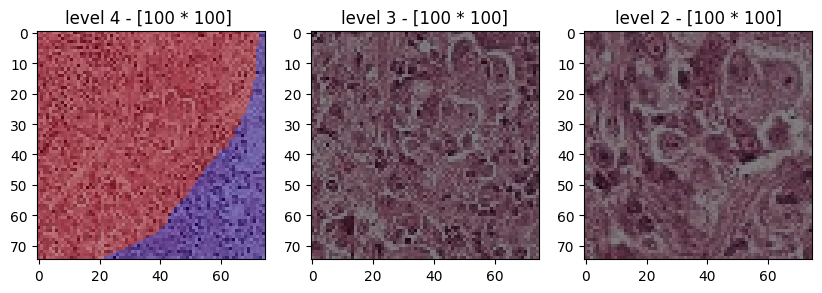

In [ ]:
print("Cancerous Cell Flag- ",y[1645])

fig, axs = plt.subplots(1, 3,figsize=(10, 10),dpi=100)
axs[0].imshow(patches_level_4[1645])
axs[0].imshow(mask_level_4[1645],cmap='jet', alpha=0.5)
axs[0].set_title("level 4 - [100 * 100] ")

axs[1].imshow(patches_level_3[1645])
axs[1].imshow(mask_level_3[1645],cmap='jet', alpha=0.5)
axs[1].set_title("level 3 - [100 * 100]")

axs[2].imshow(patches_level_2[1645])
axs[2].imshow(mask_level_2[1645],cmap='jet', alpha=0.5)
axs[2].set_title("level 2 - [100 * 100]")


Cancerous Cell Flag -  0


Text(0.5, 1.0, 'level 2 - [100 * 100]')

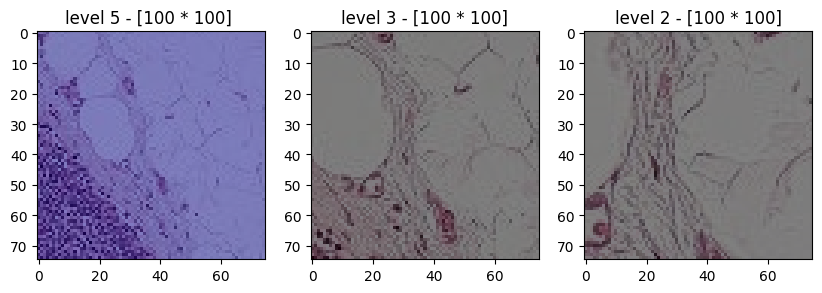

In [ ]:
print("Cancerous Cell Flag - ",y[1000])

fig, axs = plt.subplots(1, 3,figsize=(10, 10),dpi=100)
axs[0].imshow(patches_level_4[1000])
axs[0].imshow(mask_level_4[1000],cmap='jet', alpha=0.5)
axs[0].set_title("level 5 - [100 * 100] ")

axs[1].imshow(patches_level_3[1000])
axs[1].imshow(mask_level_3[1000],cmap='jet', alpha=0.5)
axs[1].set_title("level 3 - [100 * 100]")

axs[2].imshow(patches_level_2[1000])
axs[2].imshow(mask_level_2[1000],cmap='jet', alpha=0.5)
axs[2].set_title("level 2 - [100 * 100]")


In [ ]:
del patches_level_4, patches_level_3, patches_level_2, y
gc.collect()

41

In [ ]:
del mask_level_4, mask_level_3, mask_level_2
gc.collect()

0

**Preparing Test Set**

In [ ]:
test_slide = ['/content/gdrive/My Drive/ADL_Project_Data/tumor_101.tif']
test_masks = ['/content/gdrive/My Drive/ADL_Project_Data/tumor_101_mask.tif']

level = 4
requiredPatchSize = 75
patches_level_4, mask_level_4, \
 patches_level_3, mask_level_3, \
  patches_level_2, mask_level_2, y = \
  getPatches(test_slide,test_masks,level,requiredPatchSize,True)

Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_091.tif
Total Patches within this slide 2244


Total Patches from all slides 2244
Cancerous Patches 53
Normal Patches 2191


In [ ]:
path = '/content/gdrive/My Drive/ADL'
test_filename = "test_1.pkl"
with open(os.path.join(path, test_filename), 'wb') as f:
    pickle.dump([patches_level_4, patches_level_3, patches_level_2, y], f, protocol=-1)

In [ ]:
del patches_level_4, mask_level_4, \
  patches_level_3,mask_level_3, \
  patches_level_2,mask_level_2, y
gc.collect()

57

In [ ]:
test_slide = ['/content/gdrive/My Drive/ADL_Project_Data/tumor_110.tif']
test_masks = ['/content/gdrive/My Drive/ADL_Project_Data/tumor_110_mask.tif']

level = 4
requiredPatchSize = 75

patches_level_4, mask_level_4, \
 patches_level_3, mask_level_3, \
  patches_level_2, mask_level_2, y = \
        getPatches(test_slide,test_masks,level,requiredPatchSize,True)

Processing Slide /content/gdrive/My Drive/ADL_Project_Data/tumor_110.tif
Total Patches within this slide 4602


Total Patches from all slides 4602
Cancerous Patches 850
Normal Patches 3752


In [ ]:
path = '/content/gdrive/My Drive/ADL'
test_filename = "test_2.pkl"
with open(os.path.join(path, test_filename), 'wb') as f:
    pickle.dump([patches_level_4, patches_level_3, patches_level_2, y], f, protocol=-1)